<a href="https://colab.research.google.com/github/ImajiPietersz/FYP/blob/main/GAN_3_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


#DATASET_PATH = '/content/drive/MyDrive/VibrationNoise/machine2_with_noise.csv'
DATASET_PATH = '/content/drive/MyDrive/ LoRaWANdataset/machine_2_with_Noise_sensor1.csv'

IMP_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis', 'XCrestFactor', 
           'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement', 'YOAVelocity', 
           'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg', 'target']
X_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis', 'XCrestFactor', 
         'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement', 'YOAVelocity', 
         'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg']
TAR_COL = 'target'

df = pd.read_csv(DATASET_PATH)[IMP_COL]

<ipython-input-4-ee1ddc9bd828>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target -= 1
<ipython-input-4-ee1ddc9bd828>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target *= 40


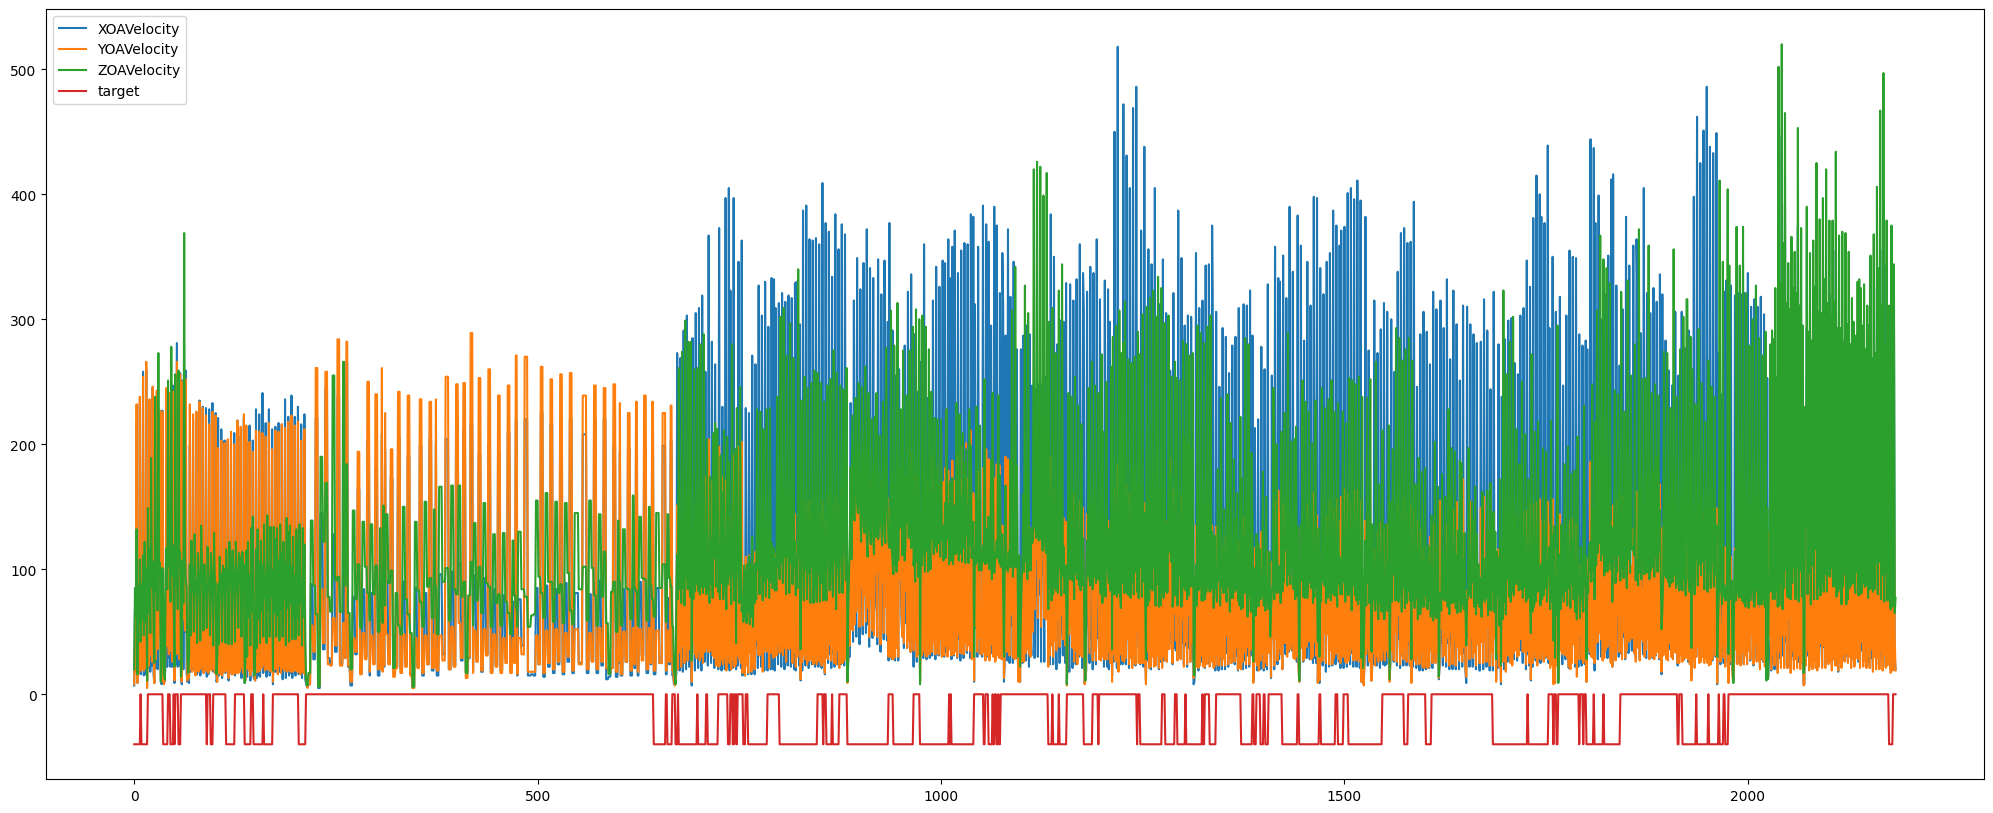

In [4]:
features = ['XOAVelocity','YOAVelocity','ZOAVelocity']
df1 = df[features+['target']]
df1.target -= 1 
df1.target *= 40
plt.figure(figsize=(25,10)) 
plt.plot(df1)
plt.legend(df1.columns)
plt.show()

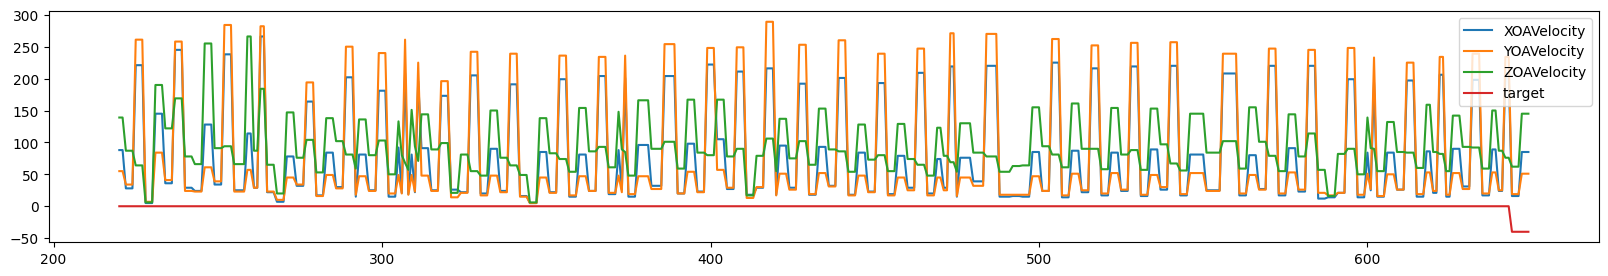

In [23]:
plt.figure(figsize=(20,3)) 
plt.plot(df1[220:650])
plt.legend(df1.columns)
plt.show()

In [5]:
def generateFrames(size = 6,overlap = True):

  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 1 if overlap else size) if i < len(df) - size]
  
  data = []
  labels = []

  for d in list_of_dfs:
    if(len(d)==size):
      values = d[features].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      data.append(values)

      # FIX HERE label as 1 if not noisy false otherwise
      labels.append(d['target'].sum() < 2)

  labels = np.asarray(labels, dtype=bool) 
  data = np.array(data)

  return (data,labels)

def splitTrainTest(ratio, data, labels):
  
  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,labels_train, x_test,labels_test)

In [7]:
frames, labels = generateFrames(12)
train_data, train_labels, test_data, test_labels = splitTrainTest(0.7, frames, labels)

In [12]:
def plotUsingAutoEncoder(model):
  size = 12
  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 12) if i < len(df) - 12]
    
  denoised = []
  

  for d in list_of_dfs:
    if(len(d) == size):
      values = d[features].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      encoded_data = model.encoder( np.array([values])).numpy()
      [values] = model.decoder(encoded_data).numpy()
      values = (np.array(values) * (max_val - min_val).numpy())   + min_val.numpy()
      denoised = np.concatenate((np.array(denoised) , np.array(values)))

  denoised = np.reshape(np.array(denoised), (-1, len(features)))
  #print(denoised)
  column_names=['denoised_XOAVelocity','denoised_YOAVelocity','denoised_ZOAVelocity']
  df_1 = pd.DataFrame(denoised, columns=column_names) 
  
  df_1.to_csv('denoised_velocities.csv')


  noise = np.reshape(df[features].values.flatten(), (-1, len(features)))


  plt.figure(figsize=(20,5)) 
  plt.plot(noise)
  plt.plot(denoised, color="red")
  plt.legend(labels=["Input", "Reconstruction"])
  plt.show()


In [8]:
class Discriminator(Model):
   def __init__(self):
    super(Discriminator, self).__init__()
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(features)*12,) ),
        tf.keras.layers.Dense(12, activation='softmax'),
        tf.keras.layers.Dense(6, activation='softmax'),
        tf.keras.layers.Dense(3, activation='softmax'),
        tf.keras.layers.Dense(1)
    ])
  
   def call(self, x):
    return self.model(x)

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(36, activation="relu"),
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(12, activation="sigmoid"),
      layers.Dense(24, activation="sigmoid"),
      layers.Dense(36, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

generator = Generator()
discriminator = Discriminator()

generator.compile(optimizer='adam', loss='mae')
discriminator.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

# generator.fit(train_data, train_data, epochs = 20, validation_data=(test_data, test_data))
discriminator.fit(train_data, train_labels, epochs=10)

# real --> Without noise
# fake -> With noise

Epoch 1/10
48/48 [==============================] - 1s 2ms/step - loss: 0.7331 - accuracy: 0.7803
Epoch 2/10
48/48 [==============================] - 0s 2ms/step - loss: 0.6822 - accuracy: 0.7803
Epoch 3/10
48/48 [==============================] - 0s 2ms/step - loss: 0.6414 - accuracy: 0.7803
Epoch 4/10
48/48 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.7803
Epoch 5/10
48/48 [==============================] - 0s 2ms/step - loss: 0.5857 - accuracy: 0.7803
Epoch 6/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5682 - accuracy: 0.7803
Epoch 7/10
48/48 [==============================] - 0s 2ms/step - loss: 0.5558 - accuracy: 0.7803
Epoch 8/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5468 - accuracy: 0.7803
Epoch 9/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5408 - accuracy: 0.7803
Epoch 10/10
48/48 [==============================] - 0s 2ms/step - loss: 0.5364 - accuracy: 0.7803


In [9]:
max_epochs = 5
learning_rate_G = 0.001
generator_optimizer = tf.optimizers.Adam(learning_rate_G )

Epoch 0 Starting
Epoch 0 DONE


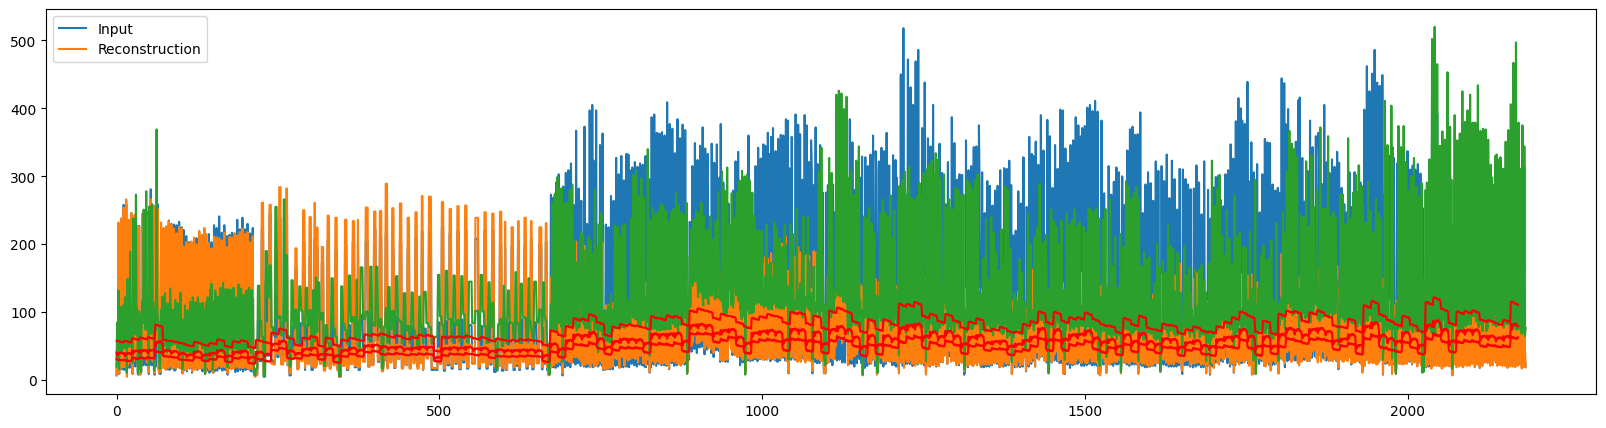

Epoch 1 Starting
Epoch 1 DONE


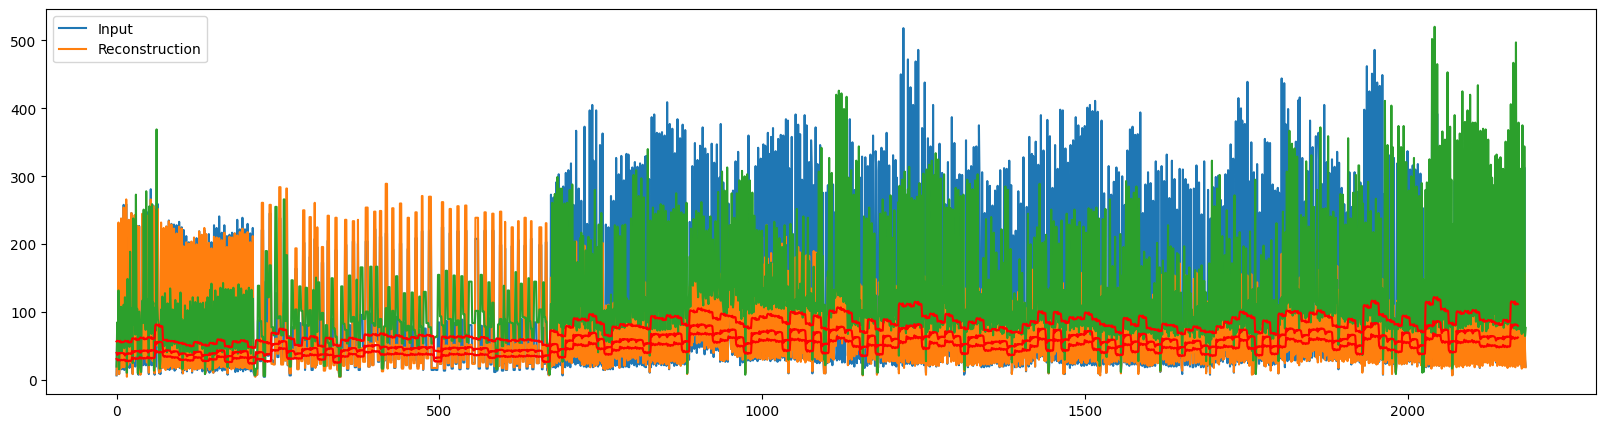

Epoch 2 Starting
Epoch 2 DONE


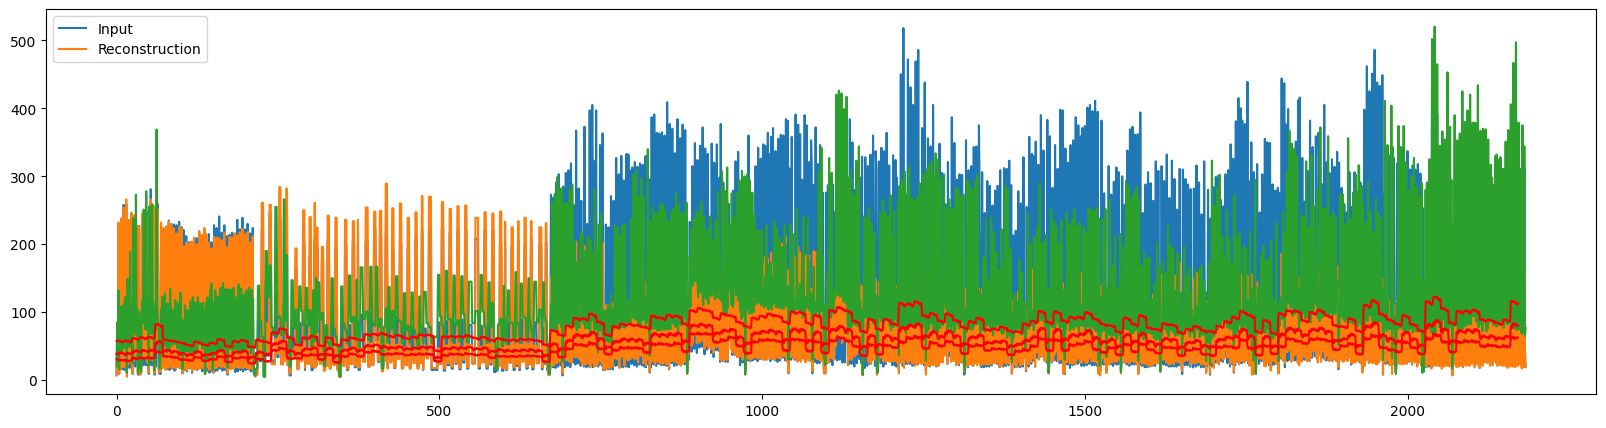

Epoch 3 Starting
Epoch 3 DONE


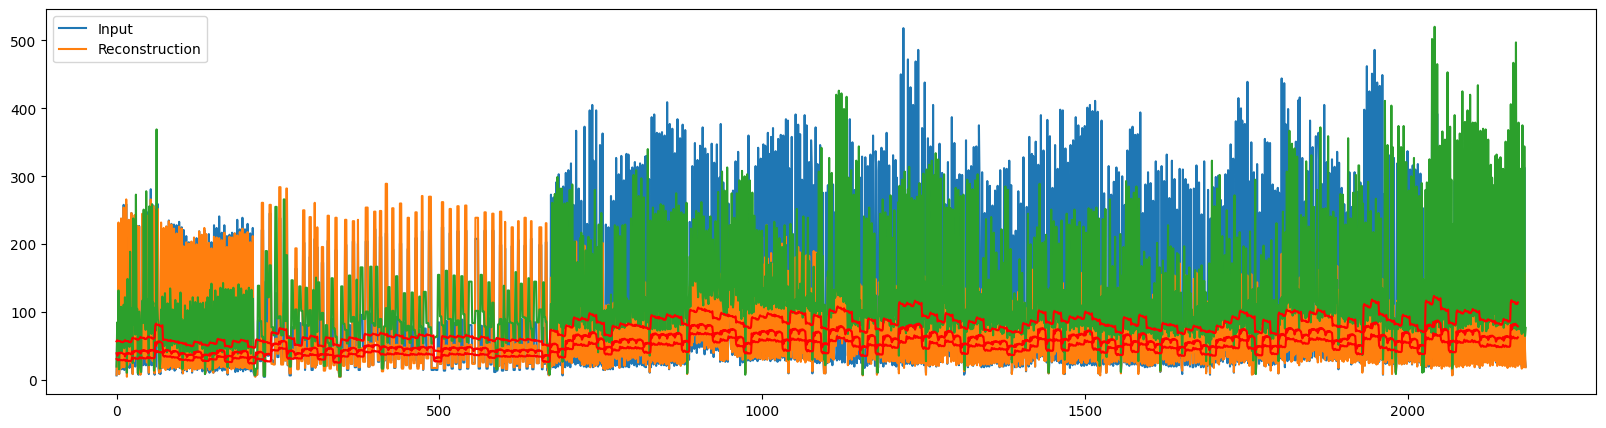

Epoch 4 Starting
Epoch 4 DONE


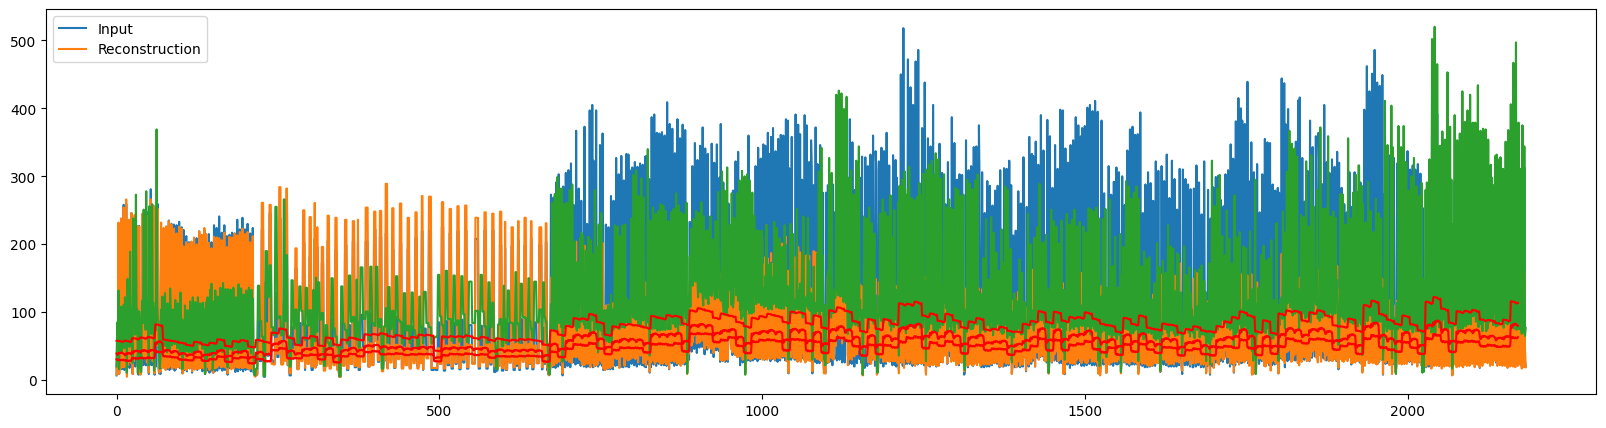

In [13]:
step = 0
for epoch in range(max_epochs):
  print("Epoch " + str(epoch) +" Starting")

  for frame in train_data:
    #print(frame)
    with tf.GradientTape() as gen_tape:
      output = generator(np.array([frame]))
      disc_output = discriminator(np.array(output))
     
      mae = tf.keras.losses.MeanAbsoluteError() 
      gen_loss = mae(frame, output[0]) * -disc_output[0][0]

      # calculate loss
      #gen_loss = generator_loss(fake_logits)
    # print(gen_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    # print(gen_loss)
    # print(gradients_of_generator)
    # print(" ++++ ")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    # epochs = step * batch_size / float(len(train_data))
  print("Epoch " + str(epoch) +" DONE")
  plotUsingAutoEncoder(generator)

# print(generator.variables)

In [14]:
denoised_velocities = pd.read_csv('/content/denoised_velocities.csv')

In [15]:
denoised_velocities.head()

,Unnamed: 0,denoised_XOAVelocity,denoised_YOAVelocity,denoised_ZOAVelocity
0,0,30.660719,39.343002,57.758942
1,1,30.385334,37.207859,58.086369
2,2,29.407261,37.701691,57.935963
3,3,30.454271,40.110844,57.624420
4,4,30.228439,39.497200,57.678276


In [22]:
df['XOAVelocity'][220:650]

220    88
221    88
222    28
223    28
224    28
       ..
645    16
646    16
647    85
648    85
649    85
Name: XOAVelocity, Length: 430, dtype: int64

In [16]:
def snr(references, estimates):
    delta = 1e-7  # avoid numerical errors
    num = np.mean(np.square(references))
    den = np.mean(np.square(references - estimates))
    num += delta
    den += delta
    return 10 * np.log10(num / den)

In [17]:
snr(df['XOAVelocity'][220:650], denoised_velocities['denoised_XOAVelocity'][220:650])

1.9987686460732792

In [18]:
snr(df['YOAVelocity'][220:650], denoised_velocities['denoised_YOAVelocity'][220:650])

1.8719245574047025

In [19]:
snr(df['ZOAVelocity'][220:650], denoised_velocities['denoised_ZOAVelocity'][220:650])

5.800302295997991